0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
101.0
102.0
103.0
104.0
105.0
106.0
107.0
108.0
109.0
110.0
111.0
112.0
113.0
114.0
115.0
116.0
117.0
118.0
119.0
120.0
121.0
122.0
123.0
124.0
125.0
126.0
127.0
128.0
129.0
130.0
131.0
132.0
133.0
134.0
135.0
136.0
137.0
138.0
139.0
140.0
141.0
142.0
143.0
144.0
145.0
146.0
147.0
148.0
149.0
150.0
151.0
152.0
153.0
154.0
155.0
156.0
157.0
158.0
159.0
160.0
161.0
162.0
163.0
164.0
165.0
166.0
167.0
168.0
169.0
170.0
171.0
172.0
173.0
174.0
175.0
176.0
177.0
178.0
179.0
180.0
181.0
182.0
183.0
184.0


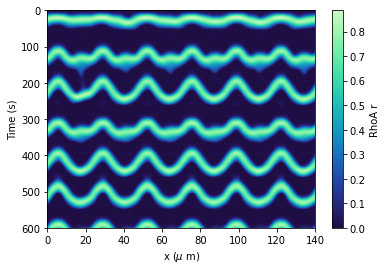

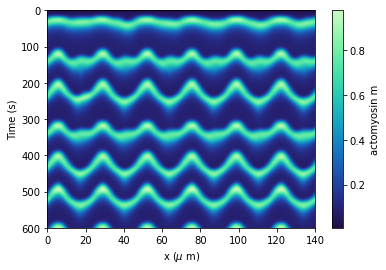

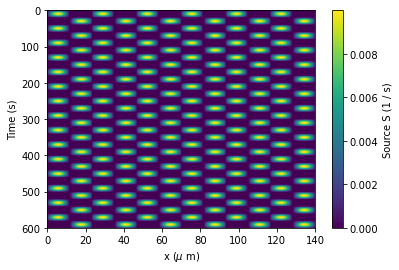

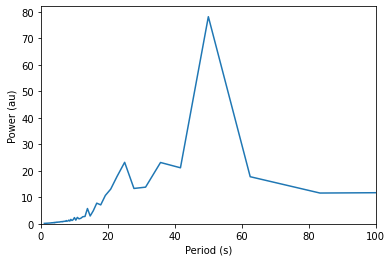

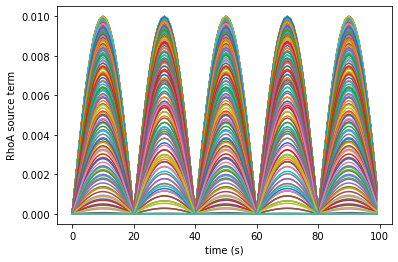

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""

@author: michaelstaddon and Michael Werner
"""

from fipy import (CellVariable, PeriodicGrid1D, Viewer, TransientTerm, DiffusionTerm,
                  UniformNoiseVariable, LinearLUSolver,
                  ImplicitSourceTerm, ExponentialConvectionTerm)

import seaborn

import matplotlib.pyplot as plt
import numpy as np


# Nice colour maps
myo_cmap = seaborn.cubehelix_palette(start=1 - 3/4, rot=1/2,
                                     light=0.1, dark=0.95, hue=2,
                                     as_cmap=True)

rho_cmap = seaborn.cubehelix_palette(start=1 - 3/4, rot=-1/2,
                                     light=0.1, dark=0.9, hue=2,
                                     as_cmap=True)


Br=6.8744e-4
a=0.1609
A=0.3833
g=0.1787
G=0.01
Bm=0.0076
ka=0.1408
kd=0.0828
Dr=0.1
Dm=0.01
gamma=1
tau=5
lam=14.3
sigma0= 24.9 * 2,
sigma0= 0,
m0=1
phi=1
duration=600
dt=1
nx=250
L=140
    
# Define mesh size and number of points

dx = L / nx
    
mesh = PeriodicGrid1D(dx, nx)

# Function to modify the RhoA source term S
# Just return a numpy array of the same size
def set_rho_source(S, x, t):
    """
    Arguments:
        S: array, previous values of source term S
        x: array, spatial locations
        t: float, the current time
    """

    
    # An example here is just a periodic in x and t source term
    t_period = 40
    x_frequency = 6
    
    # Base source and oscilation amplitude
    
    S0 = 0.00
    dS = 0.01
    
    # Define oscillatory input
    x_norm = (mesh.x > 0) * (mesh.x <140)

    t_norm = t * 2 * np.pi
 
    a = t * 2 * np.pi
    b = np.sin(a / t_period)
    if b > 0:
        t_adj = b
    else:
        t_adj = 0
        
    a = t * 2 * np.pi
    b = np.sin(a / t_period)
    if b > 0:
        t_adj5 = 0
    else:
        t_adj5 = abs(b)
         
    c = x / x.max() * 2 * np.pi
    x_adj = np.sin(c * x_frequency)
    x_adj[x_adj<0] = 0
        
    c = x / x.max() * 2 * np.pi
    x_adj5 = np.sin((c+0.5) * x_frequency)
    x_adj5[x_adj5<0] = 0
    
    # Out puts an array
    return   (S0 + dS * x_norm * x_adj * t_adj)  +  (S0 + dS *x_adj5 * x_norm* t_adj5)

def run_sim(savename,
            Br=6.8744e-4,
            a=0.1609,
            A=0.3833,
            g=0.1787,
            G=0.01,
            Bm=0.0076,
            ka=0.1408,
            kd=0.0828,
            Dr=0.1,
            Dm=0.01,
            gamma=1,
            tau=5,
            lam=14.3,
            #sigma0= 24.9 * 2,
            sigma0= 0,
            m0=1,
            phi=1,
            duration=600,
            dt=1,
            nx=250,
            L=140):
    
    # Define mesh size and number of points

    dx = L / nx
    
    mesh = PeriodicGrid1D(dx, nx)
    
    
    # Variables to use
    r = CellVariable(name='r', mesh=mesh, hasOld=1)
    m = CellVariable(name='m', mesh=mesh, hasOld=1)
    v = CellVariable(name='v', mesh=mesh, hasOld=1)
    
    # RhoA source
    S = CellVariable(name='S', mesh=mesh, hasOld=True)
    
    # Add some random noise
    r.setValue(UniformNoiseVariable(mesh=mesh, minimum=0, maximum=0.01))
    m.setValue(UniformNoiseVariable(mesh=mesh, minimum=0, maximum=0.01))    
    
                     
    # Define the equations using their special classes
    # TransientTerm = d var / dt
    # Convection Term = u dot grad(v) - here I do it by x and y components
    # Source term for reactions - use this instead of equations for the solver to work better
    # DiffusionTerm for diffusion...
    eq_r = (TransientTerm(var=r) ==
            + ImplicitSourceTerm(coeff=1, var=S)
            - ExponentialConvectionTerm(coeff=[[1.0]] * v * phi, var=r)
            + ImplicitSourceTerm(coeff=(a / (A+r) - g * m / (G+r)), var=r)
            + DiffusionTerm(var=r, coeff=Dr))
            
    eq_m = (TransientTerm(var=m) ==
            Bm
            - ExponentialConvectionTerm(coeff=[[1.0]] * v, var=m)
            + ImplicitSourceTerm(coeff=ka * r, var=r)
            - ImplicitSourceTerm(coeff=kd, var=m)
            + DiffusionTerm(var=m, coeff=Dm))
    
    
    eq_v = (gamma * tau * TransientTerm(var=v) ==
            DiffusionTerm(coeff=lam * lam, var=v) 
            - ImplicitSourceTerm(coeff=gamma, var=v)
            + sigma0 * m.grad.dot([[1.0]]) * (m0 / (m0 + m) ** 2))
    
    # We upate S manually but need a dummy equation for fipy to run
    eq_S = TransientTerm(var=S) == 0
    
    # Couple them into one big equation
    eq = eq_r & eq_m & eq_v & eq_S
    
    elapsed = 0.0
    
    # You can use the viewer when the mesh is a weird shape eg sphere
    # viewer = Viewer(vars=(r,m,u,v), datamin=0.)

    i = 0
    
    rs = []
    ms = []
    vs = []
    Ss = []
    while elapsed < duration:
        print(elapsed)
        # Old values are used for sweeping when solving nonlinear values
        r.updateOld()
        m.updateOld()
        v.updateOld()
        S.updateOld()
        
        elapsed += dt
        
        # Optional sweep instead of solve - use for nonlinear problems
        res = 1e5
        steps = 0
        while res > 1e-3 and steps < 5:
            res = eq.sweep(dt=dt)
            steps += 1
        
        
        # The variable values are just numpy arrays so easy to use!
        rs.append(r.value.copy())
        ms.append(m.value.copy())
        vs.append(v.value.copy())
        Ss.append(S.value.copy())
        
        # Update the time and space dependent source term!
        S.value = set_rho_source(S.value, mesh.x.value, elapsed)
        
        i += 1
        
    return rs, ms, vs, Ss


if __name__ == '__main__':

    sigma = 20
    duration = 600
    
    
    # Schematic
    rs, ms, vs, Ss = run_sim('time_varying_source.npy', sigma0=sigma, duration=duration)
    
    plt.imshow(rs, extent=[0, 140, duration, 0], aspect='auto',
               cmap=rho_cmap)
    plt.colorbar(label='RhoA r')
    plt.xlabel('x ($\mu$ m)')
    plt.ylabel('Time (s)')
    plt.show()
    
    plt.imshow(ms, extent=[0, 140, duration, 0], aspect='auto',
               cmap=rho_cmap)
    plt.colorbar(label='actomyosin m')
    plt.xlabel('x ($\mu$ m)')
    plt.ylabel('Time (s)')
    plt.show()
    
    plt.imshow(Ss, extent=[0, 140, duration, 0], aspect='auto',
               cmap='viridis')
    plt.colorbar(label='Source S (1 / s)')
    plt.xlabel('x ($\mu$ m)')
    plt.ylabel('Time (s)')
    plt.show()
    
    rs = np.array(rs)
    
    # Get the fourier transform of the RhoA field at each position
    fs = []
    for x in range(rs.shape[1]):
        # Skip first 100s until we get regular waves
        f = np.fft.fft(rs[100:, x])
        
        fs.append(f)


    fs = np.array(fs)
    
    # Average over the spatial dimensions to get the frequency power
    power = np.mean(np.abs(fs), axis=0)
    
    # Only take the first half since it is mirrored ie power[10] = power[-10]
    power = power[:len(power) // 2]
    
    period = len(power) / np.arange(1, len(power), 1)

    plt.plot(period, power[1:])
    plt.xlabel('Period (s)')
    plt.ylabel('Power (au)')
    plt.xlim(0,100)
    plt.ylim(0, None)
    plt.show()
    
    ST = np.array(Ss)
    plt.plot(ST[0:100,:])
    plt.xlabel('time (s)')
    plt.ylabel('RhoA source term')
    plt.show()